In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re
from scipy.stats import norm

In [2]:
# https://data.census.gov/cedsci/table?g=0400000US55.860000&tid=ACSST5Y2019.S1901&hidePreview=false

In [3]:
with open("ACSST5Y2019.S1901_data_with_overlays_2021-04-16T140913.csv") as f:
    reader = csv.reader(f)
    rows = list(reader)

df = pd.DataFrame(rows[2:], columns=rows[1])
df = df.set_index(df["Geographic Area Name"].apply(lambda z: z[-5:]))
df.index.name = "zip"
df.head()

,id,Geographic Area Name,Estimate!!Households!!Total,Margin of Error!!Households!!Total,"Estimate!!Households!!Total!!Less than $10,000","Margin of Error!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Margin of Error!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Margin of Error!!Households!!Total!!$15,000 to $24,999",...,Estimate!!Nonfamily households!!Median income (dollars),Margin of Error!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),Margin of Error!!Nonfamily households!!Mean income (dollars),Estimate!!Nonfamily households!!PERCENT ALLOCATED!!Household income in the past 12 months,Margin of Error!!Nonfamily households!!PERCENT ALLOCATED!!Household income in the past 12 months,Estimate!!Nonfamily households!!PERCENT ALLOCATED!!Family income in the past 12 months,Margin of Error!!Nonfamily households!!PERCENT ALLOCATED!!Family income in the past 12 months,Estimate!!Nonfamily households!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Nonfamily households!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months
zip,,,,,,,,,,,,,,,,,,,,,
53001,8600000US53001,ZCTA5 53001,823,50,2.3,1.6,0.9,0.7,7.0,2.5,...,54135,9066,66412,13642,(X),(X),(X),(X),43.1,(X)
53002,8600000US53002,ZCTA5 53002,991,119,5.0,5.8,2.0,1.7,2.9,3.6,...,51940,7013,56569,12490,(X),(X),(X),(X),36.0,(X)
53003,8600000US53003,ZCTA5 53003,63,22,0.0,23.9,7.9,11.5,25.4,16.6,...,22708,8610,20971,5369,(X),(X),(X),(X),52.4,(X)
53004,8600000US53004,ZCTA5 53004,1276,73,1.3,0.9,2.9,2.3,4.9,2.3,...,52545,9825,56232,7585,(X),(X),(X),(X),30.1,(X)
53005,8600000US53005,ZCTA5 53005,7622,170,1.4,0.7,1.3,0.9,4.6,1.5,...,55242,9189,69704,7029,(X),(X),(X),(X),23.7,(X)


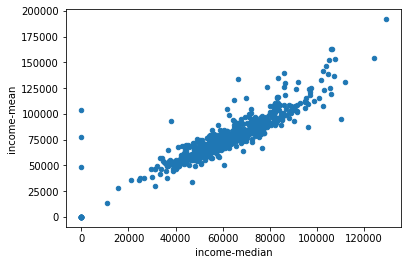

In [4]:
income = pd.DataFrame()
income["households"] = df["Estimate!!Households!!Total"].astype(int)
income["income-median"] = df["Estimate!!Households!!Median income (dollars)"].str.replace("-", "0").astype(int)
income["income-mean"] = df["Estimate!!Households!!Mean income (dollars)"].str.replace("-", "0").replace("N", "0").astype(int)
income.plot.scatter(x="income-median", y="income-mean")

In [5]:
income[["income-mean", "income-median"]].to_csv("income.csv")

In [6]:
idxs = np.random.choice(len(income), size=1000, p=income["households"] / income["households"].sum())
samp = income.iloc[idxs].copy()
samp.reset_index(inplace=True)
samp["income"] = samp["income-median"] * (np.random.rand(len(samp)) * 0.2 + 0.9)

def income_to_prob(low, high, lowp, highp):
    low *= 1000
    high *= 1000
    return (np.clip(samp["income"], low, high) - low) / (high - low) * (highp - lowp) + lowp
samp["soda"] = 0.10 + samp["income"] / 1000000
samp["coffee"] = 0.15 + samp["income"] / 1000000
samp["wine"] = np.clip(samp["income"] / 1000, 60, 100) / 100 - 0.5 #income_to_prob(50, 100, 0.05, 0.8)
samp.head()

,zip,households,income-median,income-mean,income,soda,coffee,wine
0,54750,397,67614,83863,69370.977215,0.169371,0.219371,0.193710
1,54812,1943,49958,63414,50784.506515,0.150785,0.200785,0.100000
2,54942,3749,102383,107470,96429.192594,0.196429,0.246429,0.464292
3,53218,13875,38584,51411,40965.318636,0.140965,0.190965,0.100000
4,53213,11420,80139,107369,74191.634417,0.174192,0.224192,0.241916


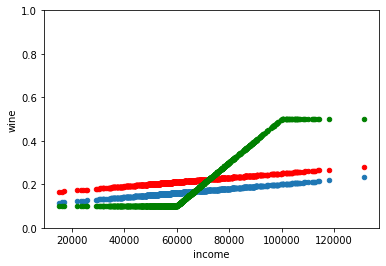

In [7]:
ax = samp.plot.scatter(x="income", y="soda", ylim=(0,1))
samp.plot.scatter(x="income", y="coffee", ax=ax, color="red")
samp.plot.scatter(x="income", y="wine", ax=ax, color="green")

In [8]:
samp2 = samp.copy() #TODO: remove

In [9]:
samp[["soda", "coffee", "wine"]] = samp[["soda", "coffee", "wine"]] > np.random.rand(len(samp), 3)
samp.head()

,zip,households,income-median,income-mean,income,soda,coffee,wine
0,54750,397,67614,83863,69370.977215,False,False,False
1,54812,1943,49958,63414,50784.506515,True,False,False
2,54942,3749,102383,107470,96429.192594,True,True,False
3,53218,13875,38584,51411,40965.318636,False,False,False
4,53213,11420,80139,107369,74191.634417,False,False,False


In [10]:
cols = ["zip", "income", "soda", "coffee", "wine"]
samp[cols].iloc[:500].to_csv("visits1.csv", index=False)
samp[cols].iloc[500:].to_csv("visits2.csv", index=False)
samp.head()

,zip,households,income-median,income-mean,income,soda,coffee,wine
0,54750,397,67614,83863,69370.977215,False,False,False
1,54812,1943,49958,63414,50784.506515,True,False,False
2,54942,3749,102383,107470,96429.192594,True,True,False
3,53218,13875,38584,51411,40965.318636,False,False,False
4,53213,11420,80139,107369,74191.634417,False,False,False


## Debug

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression

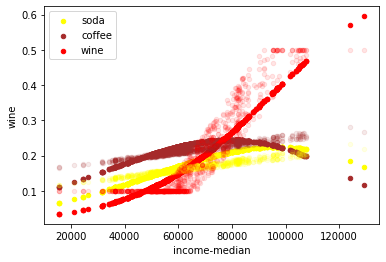

In [12]:
model = Pipeline([
    ("poly", PolynomialFeatures(3)),
    ("std", StandardScaler()),
    ("lr", LogisticRegression()),
])
xcol = "income-median"

ycols = ["soda", "coffee", "wine"]
pcols = ["psoda", "pcoffee", "pwine"]
for pcol, ycol in zip(pcols, ycols):
    samp[pcol] = model.fit(samp[[xcol]], samp[ycol]).predict_proba(samp[[xcol]])[:,1]
samp["choice"] = np.array(ycols)[samp[pcols].values.argmax(axis=1)]

ax = samp.plot.scatter(x=xcol, y="psoda", label="soda", color="yellow")
samp.plot.scatter(x=xcol, y="pcoffee", ax=ax, label="coffee", color="brown")
samp.plot.scatter(x=xcol, y="pwine", ax=ax, label="wine", color="red")

samp2.plot.scatter(x=xcol, y="soda", ax=ax, color="yellow", alpha=0.1)
samp2.plot.scatter(x=xcol, y="coffee", ax=ax, color="brown", alpha=0.1)
samp2.plot.scatter(x=xcol, y="wine", ax=ax, color="red", alpha=0.1)

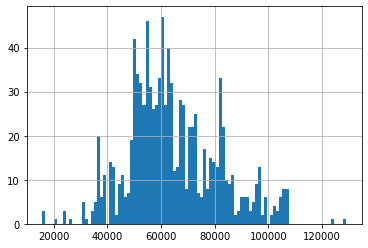

In [13]:
samp["income-median"].hist(bins=100)

In [14]:
samp["choice"].value_counts()

coffee    758
wine      242
Name: choice, dtype: int64

In [15]:
samp[ycols].astype(int).values.mean()

0.19333333333333333

In [16]:
samp[ycols].astype(int).max(axis=1).values.mean()

0.48

In [17]:
samp[ycols].astype(int).min(axis=1).values.mean()

0.004

In [19]:
samp

,zip,households,income-median,income-mean,income,soda,coffee,wine,psoda,pcoffee,pwine,choice
0,54750,397,67614,83863,69370.977215,False,False,False,0.187046,0.236445,0.189047,coffee
1,54812,1943,49958,63414,50784.506515,True,False,False,0.143117,0.202880,0.107957,coffee
2,54942,3749,102383,107470,96429.192594,True,True,False,0.222524,0.212774,0.430399,wine
3,53218,13875,38584,51411,40965.318636,False,False,False,0.114335,0.172918,0.073564,coffee
4,53213,11420,80139,107369,74191.634417,False,False,False,0.211109,0.243834,0.267700,wine
...,...,...,...,...,...,...,...,...,...,...,...,...
995,54956,18538,64329,93541,65423.362666,False,False,False,0.179426,0.231956,0.171212,coffee
996,53083,8335,72827,84736,66338.827922,False,False,False,0.198166,0.241501,0.219851,coffee
997,53590,15914,82273,94848,79659.723513,True,False,False,0.214174,0.243388,0.282525,wine
998,53089,7432,92951,110908,97280.471521,False,False,True,0.223619,0.233063,0.360416,wine


In [21]:
pd.read_csv("income.csv")

,zip,income-mean,income-median
0,53001,94015,72578
1,53002,86643,77708
2,53003,71386,47292
3,53004,90837,81250
4,53005,138901,104534
...,...,...,...
769,54982,68204,51354
770,54983,72233,60263
771,54984,66557,52352
772,54985,0,0
